In [1]:
import os

os.environ["USE_PYGEOS"] = "0"

import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

from dea_tools.plotting import display_map, rgb

from PIL import Image
import matplotlib.image


/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41973 instead
  warnings.warn(


In [2]:
def get_meditions(product):
    query = {
        "product": product,
        "y": (-51.02, -50.95), 
        "x": (-73.3, -73.175),
        "time": ("2000-01-01", "2024-01-01"),
        "output_crs": "EPSG:32719",
        "resolution": (-30, 30),
        "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
        "group_by": "solar_day"
    }
    return dc.load(**query)

In [3]:
def plot(image_array, gray=True):
    plt.figure().set_figwidth(30)
    plt.grid(False)
    plt.axis('off')
    if gray:
        plt.imshow(image_array, cmap='gray')
    else:
        plt.imshow(image_array)
    plt.show()

def plot_all(image_array, gray=False):
    plt.figure().set_figwidth(30)
    plt.grid(False)
    plt.axis('off')
    if gray:
        plt.imshow(np.concatenate(image_array,axis=1), cmap='gray')
    else:
        plt.imshow(np.concatenate(image_array,axis=1))
    plt.show()

In [4]:
dc = datacube.Datacube(app='test')

products = [
    "landsat5_c2l2_sr", "landsat5_c2l2_st",
    "landsat8_c2l2_sr", "landsat8_c2l2_st",
    "landsat9_c2l2_sr", "landsat9_c2l2_st",
]

bandas = {}
satel_data = {}
for p in products:
    bandas[p] = []
    satel_data[p] = get_meditions(p)
    for n in dc.list_measurements(show_archived=False, with_pandas=True).loc[[p]]["name"]:
        bandas[p].append(n)

In [5]:
for ba in bandas.keys():
    print(ba, bandas[ba])

landsat5_c2l2_sr ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'atmos_opacity', 'qa_pixel', 'qa_radsat', 'cloud_qa']
landsat5_c2l2_st ['lwir', 'TRAD', 'URAD', 'DRAD', 'ATRAN', 'EMIS', 'EMSD', 'CDIST', 'qa_pixel', 'qa_radsat', 'qa']
landsat8_c2l2_sr ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel', 'qa_aerosol', 'qa_radsat']
landsat8_c2l2_st ['lwir11', 'TRAD', 'URAD', 'DRAD', 'ATRAN', 'EMIS', 'EMSD', 'CDIST', 'qa_pixel', 'qa_radsat', 'qa']
landsat9_c2l2_sr ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel', 'qa_aerosol', 'qa_radsat']
landsat9_c2l2_st ['lwir11', 'TRAD', 'URAD', 'DRAD', 'ATRAN', 'EMIS', 'EMSD', 'CDIST', 'qa_pixel', 'qa_radsat', 'qa']


In [6]:
good_pixel_flags = {
    # "snow": "not_high_confidence",
    "cloud": "not_high_confidence",
    # "cirrus": "not_high_confidence",
    "cloud_shadow": "not_high_confidence",
    "nodata": False
}

bandas_reflectancia = ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel']


"""  LANDSATA 5  """
cloud_free_mask = masking.make_mask(satel_data["landsat5_c2l2_sr"]['qa_pixel'], **good_pixel_flags)
valid_pixel_proportion = cloud_free_mask.sum(dim=("x", "y"))/(cloud_free_mask.shape[1] * cloud_free_mask.shape[2])
satel_data["landsat5_c2l2_sr"] = satel_data["landsat5_c2l2_sr"][bandas_reflectancia[1:]].sel(time=(valid_pixel_proportion >= 0.8)).persist()


"""  LANDSATA 8  """
cloud_free_mask = masking.make_mask(satel_data["landsat8_c2l2_sr"]['qa_pixel'], **good_pixel_flags)
valid_pixel_proportion = cloud_free_mask.sum(dim=("x", "y"))/(cloud_free_mask.shape[1] * cloud_free_mask.shape[2])
satel_data["landsat8_c2l2_sr"] = satel_data["landsat8_c2l2_sr"][bandas_reflectancia].sel(time=(valid_pixel_proportion >= 0.8)).persist()


"""  LANDSATA 9  """
cloud_free_mask = masking.make_mask(satel_data["landsat9_c2l2_sr"]['qa_pixel'], **good_pixel_flags)
valid_pixel_proportion = cloud_free_mask.sum(dim=("x", "y"))/(cloud_free_mask.shape[1] * cloud_free_mask.shape[2])
satel_data["landsat9_c2l2_sr"] = satel_data["landsat9_c2l2_sr"][bandas_reflectancia].sel(time=(valid_pixel_proportion >= 0.8)).persist()


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


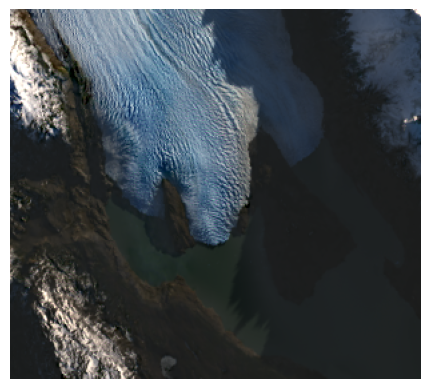

In [8]:
satel = "landsat9_c2l2_sr"
time = 1

da = satel_data[satel][["red", "green", "blue"]].isel(**{'time': [time]}).to_array().compute()
img = np.array(da.squeeze(dim='time'))
img = np.transpose(img, (1, 2, 0))/np.max(img)

plot(img)

In [12]:
satel = "landsat5_c2l2_sr"
time = 1
b = 3

for time in range(len(satel_data[satel].time)):
    # mask = satel_data[satel]["qa_pixel"].isel(time = time)
    # Image.fromarray(np.array(mask)).save(f"images/{satel}/{time}_mask.png")

    da = satel_data[satel][["red", "green", "blue"]].isel(**{'time': [time]})
    da = da.to_array()
    da = da.compute()
    img = np.array(da.squeeze(dim='time'))
    img = np.transpose(img, (1, 2, 0))/np.max(img)

    matplotlib.image.imsave(f"images/{satel}/{time}_RGB.png", img)

In [17]:
satel = "landsat9_c2l2_sr"
time = 1
b = 3

for time in range(len(satel_data[satel].time)):
    R = satel_data[satel]["red"].isel(time = time)
    mask = satel_data[satel]["qa_pixel"].isel(time = time)

    Image.fromarray(np.array(R)).save(f"images/{satel}/{time}_R.png")
    Image.fromarray(np.array(mask)).save(f"images/{satel}/{time}_mask.png")